In [25]:
import mmcv
from mmcv import *
from mmcv.runner import load_checkpoint
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result
from mmdet.datasets import to_tensor
from mmdet.datasets.transforms import ImageTransform
from mmdet.core import get_classes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
#加载模型
cfg = mmcv.Config.fromfile('configs/faster_rcnn_r50_fpn_2x-mydata.py')
cfg.model.pretrained = None

# construct the model and load checkpoint
model = build_detector(cfg.model, test_cfg=cfg.test_cfg)
_ = load_checkpoint(model, '/data2/fengche/log/latest.pth')

In [27]:
#阈值
score_thr=0.8
bbox_color='green'
text_color='green'
thickness=1
font_scale=0.5
show=True
win_name=''
wait_time=0
out_file=None
class_names=['fengche']

In [60]:
# test a single image
img = mmcv.imread('/data2/fengche/train/001908.jpg')
result = inference_detector(model, img, cfg)

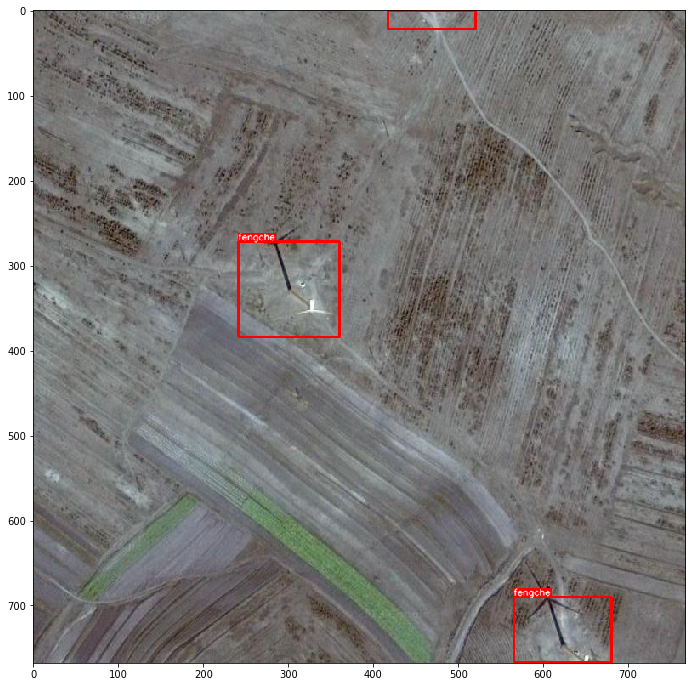

In [61]:
bboxes = np.vstack(result)
newboxes=[]
for i in range(bboxes.shape[0]):
    if(bboxes[i,-1]>score_thr):
        newboxes.append(bboxes[i,:4].astype(np.int32))
newboxes=np.asarray(newboxes)
ids=np.ones((newboxes.shape[0]),dtype='uint8')
annotations = {'image': img, 'bboxes': newboxes, 'category_id': ids}
category_id_to_name = {1: 'fengche'}
visualize(annotations, category_id_to_name)

In [3]:
import argparse
from mmcv import Config
from mmcv.runner import obj_from_dict

from mmdet import datasets, __version__
from mmdet.apis import (train_detector, init_dist, get_root_logger,
                        set_random_seed)
from mmdet.models import build_detector

In [5]:
cfg = Config.fromfile('configs/faster_rcnn_r50_fpn_2x-mydata.py')

In [3]:
cfg.data.train

{'type': 'CustomDataset',
 'ann_file': '/data2/fengche/annotations/annotations.pkl',
 'img_prefix': '/data2/fengche/train/',
 'img_scale': (768, 768),
 'img_norm_cfg': {'mean': [123.675, 116.28, 103.53],
  'std': [58.395, 57.12, 57.375],
  'to_rgb': True},
 'size_divisor': 32,
 'flip_ratio': 0.5,
 'with_mask': False,
 'with_crowd': True,
 'with_label': True}

In [5]:
import pandas as pd

In [88]:
xxx=pd.read_pickle('/data2/images-to-osm/tiles/fengche.pth')

In [89]:
xxx.head()

,ann,filename,height,image,width
0,"{'labels': [1, 1], 'bboxes_ignore': [], 'bboxe...",000000.jpg,768,"[[[54, 61, 43], [53, 60, 42], [47, 54, 36], [4...",768
1,"{'labels': [1, 1], 'bboxes_ignore': [], 'bboxe...",000001.jpg,768,"[[[34, 50, 21], [48, 64, 35], [49, 65, 36], [4...",768
2,"{'labels': [1, 1, 1], 'bboxes_ignore': [], 'bb...",000002.jpg,768,"[[[31, 45, 20], [35, 49, 24], [15, 29, 4], [28...",768
3,"{'labels': [1, 1], 'bboxes_ignore': [], 'bboxe...",000003.jpg,768,"[[[34, 32, 19], [42, 40, 27], [49, 45, 33], [4...",768
4,"{'labels': [1, 1], 'bboxes_ignore': [], 'bboxe...",000004.jpg,768,"[[[36, 49, 23], [33, 46, 20], [25, 38, 12], [2...",768


In [90]:
data=[]

In [91]:
for i in range(len(xxx)):
    ann=xxx.iloc[i,0]
    bboxes_ignore = np.zeros((0, 4))
    ann['bboxes_ignore']=bboxes_ignore.astype(np.float32)
    annotation = {
        'filename':xxx.iloc[i,1],
        'width': 768,
        'height': 768,
        'ann': ann}
    data.append(annotation)

In [6]:
mmcv.dump(data, '/data2/fengche/annotations/annotations.pkl')

NameError: name 'data' is not defined

In [6]:
train_dataset = obj_from_dict(cfg.data.train, datasets)

In [12]:
import albumentations as A
import random

In [8]:
mean = (123.675, 116.28, 103.53)
std = (58.395, 57.12, 57.375)

In [9]:
xxx=train_dataset[80]
bbox=xxx['gt_bboxes'].data
bbox=bbox.numpy()
labels=xxx['gt_labels'].data.numpy()
xxx=xxx['img'].data
xxx=xxx.numpy()
xxx=xxx.transpose(1,2,0)
xxx*=np.ones(xxx.shape)*std
xxx+=np.ones(xxx.shape) * mean
xxx=xxx.astype('uint8')
# print(xxx.shape)
# plt.imshow(xxx)
newbbox=np.zeros_like(bbox)
newbbox[:,0]=bbox[:,0]
newbbox[:,1]=bbox[:,1]
newbbox[:,2]=bbox[:,2]-bbox[:,0]
newbbox[:,3]=bbox[:,3]-bbox[:,1]

In [165]:
labels

array([1, 1])

In [14]:
light = A.Compose([
    A.RGBShift(),
    A.InvertImg(),
    A.Blur(),
    A.GaussNoise(),
    A.Flip(),
    A.RandomRotate90(),
    A.RandomSizedCrop((768-384, 768), 768, 768),
], bbox_params={'format':'pascal_voc','min_visibility': 0.4, 'label_fields': ['category_id']}, p=1)

In [23]:
augmented=light(image=xxx,bboxes=bbox, category_id=labels)

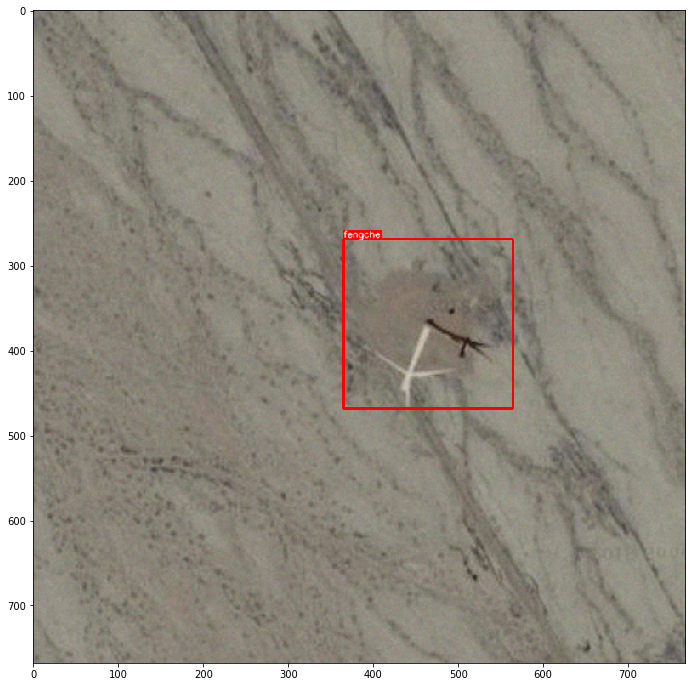

In [24]:
visualize(augmented,{1:'fengche'})

In [17]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
#     x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(bbox[0]), int(bbox[2]), int(bbox[1]), int(bbox[3])
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)